# Docling-Graph: Complete Invoice Extraction Workflow

This notebook demonstrates a complete end-to-end workflow:
1. Extract data from an invoice image using VLM backend
2. Convert to knowledge graph
3. Export and visualize results
4. Query the graph

**Requirements:**
- Install dependencies: `pip install -e .`
- GPU recommended (but works on CPU)
- Sample invoice: `examples/Data/sample_invoice.jpg`
- Template: `examples/templates/invoice.py`

## Setup and Imports

In [33]:
# Standard library imports
from pathlib import Path
import sys

# Add examples directory to path
sys.path.insert(0, str(Path.cwd().parent))

# Docling-graph imports
from docling_graph.pipeline import run_pipeline
from docling_graph.graph_converter import GraphConverter
from docling_graph.graph_visualizer import create_interactive_graph, create_static_graph
from docling_graph.graph_exporter import to_csv, to_cypher

# Visualization imports
from IPython.display import Image, Markdown, HTML, display
import networkx as nx
import pandas as pd

print("All imports successful!")

All imports successful!


## Step 1: View the Source Invoice

Let's first take a look at the invoice we'll be extracting data from.

Invoice found: ..\Data\sample_invoice.jpg


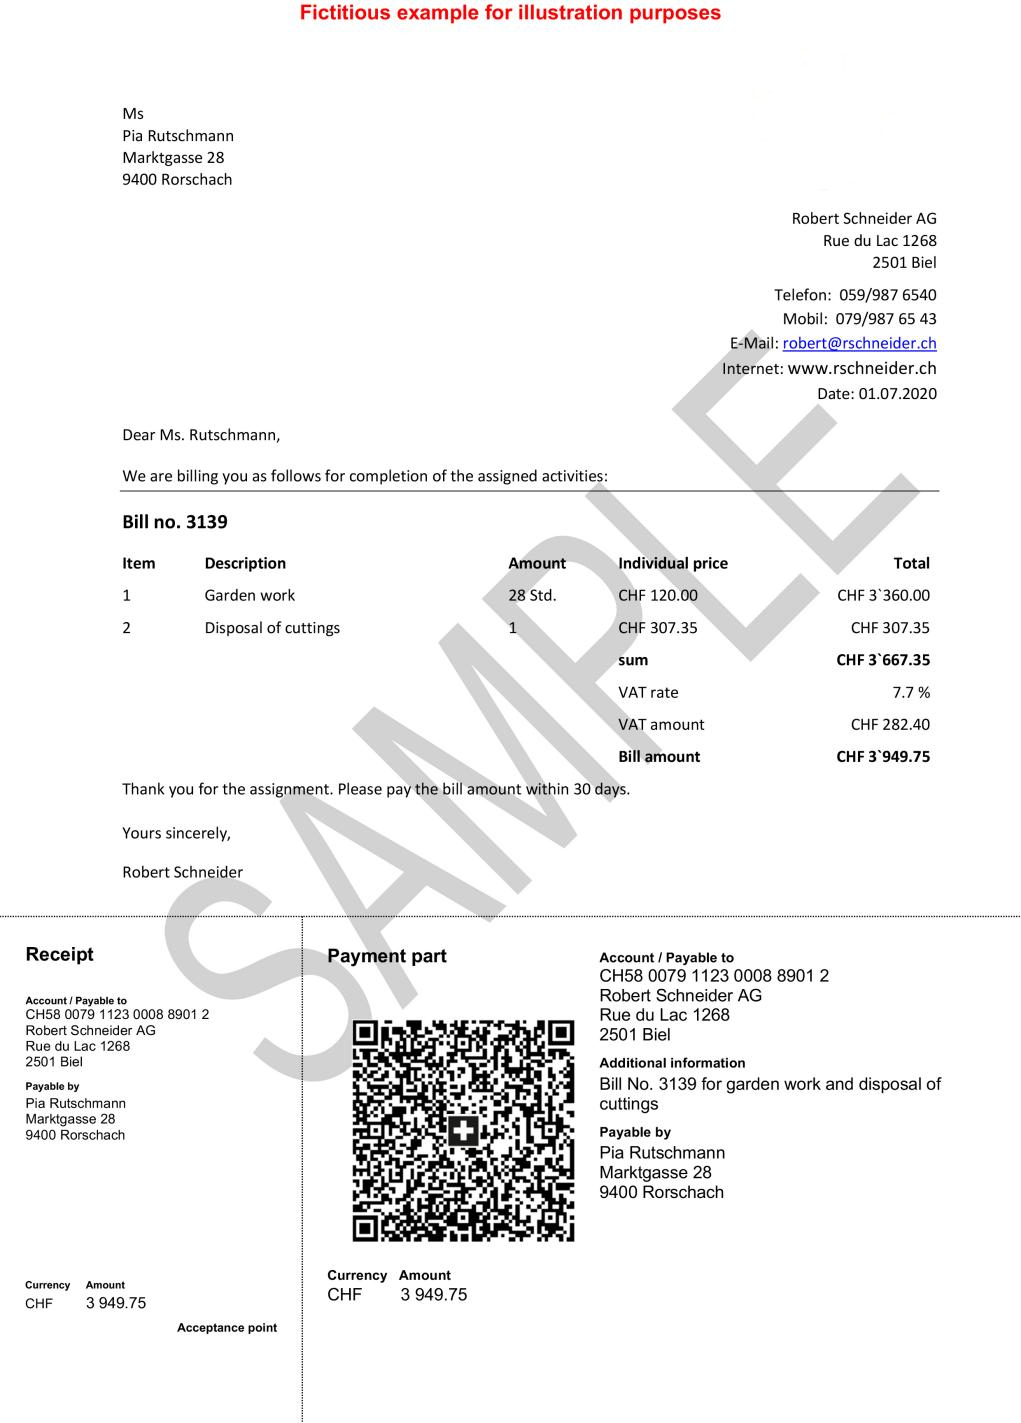

In [6]:
# Define paths
source_invoice = Path("../Data/sample_invoice.jpg")
template_path = "examples.templates.invoice.Invoice"  # Adjust based on your structure
output_dir = Path("../outputs/notebook_example")

# Check if invoice exists
if not source_invoice.exists():
    print(f"Invoice not found at: {source_invoice}")
    print("Please update the path or place a sample invoice at this location")
else:
    print(f"Invoice found: {source_invoice}")
    display(Image(filename=str(source_invoice), width=600))

## Step 2: Configure the Pipeline

We'll use the **VLM (Vision-Language Model)** backend for extraction.

**Why VLM for invoices?**
- Better understanding of visual layout
- Can handle tables, logos, and complex formatting
- No OCR preprocessing needed

In [7]:
# Pipeline configuration
config = {
    # Source document
    "source": str(source_invoice),
    
    # Template (Pydantic model for invoice)
    "template": template_path,
    
    # Processing configuration
    "processing_mode": "one-to-one",    # Single page to single invoice
    "backend_type": "vlm",              # Use Vision-Language Model for extraction
    "inference": "local",               # Local inference
    "docling_config": "vision",         # VLM pipeline (not OCR)
    
    # Output configuration
    "output_dir": str(output_dir),
    "export_format": "csv",
    "reverse_edges": False,
    
    # Model configuration
    "config": {
        "models": {
            "vlm": {
                "local": {
                    "default_model": "numind/NuExtract-2.0-8B",
                    "provider": "docling"
                }
            }
        }
    },
    
    "model_override": None,
    "provider_override": None
}

# Create output directory
output_dir.mkdir(parents=True, exist_ok=True)

print("Pipeline configured")
print(f"  Backend: {config['backend_type'].upper()}")
print(f"  Model: {config['config']['models']['vlm']['local']['default_model']}")
print(f"  Output: {output_dir}")

Pipeline configured
  Backend: VLM
  Model: numind/NuExtract-2.0-8B
  Output: ..\outputs\notebook_example


## Step 3: Run the Extraction Pipeline

This will:
1. Load the invoice image
2. Extract data using VLM
3. Validate against Pydantic schema
4. Convert to knowledge graph
5. Generate visualizations and exports

**Note:** First run will download the VLM model (~8GB). Subsequent runs are faster.

In [8]:
%%time

# Run the pipeline
try:
    print("Starting extraction pipeline...")
    print("=" * 70)
    run_pipeline(config)
    print("\n" + "=" * 70)
    print("EXTRACTION COMPLETE!")
    print("=" * 70)
except Exception as e:
    print(f"\nError: {e}")
    raise

Starting extraction pipeline...


--- Starting Docling-Graph Pipeline ---

Loading template: examples.templates.invoice.Invoice

Successfully loaded Pydantic template: Invoice

Using model: numind/NuExtract-2.0-8B (provider: docling)

[ExtractorFactory] Creating extractor:

Mode: one-to-one

Type: vlm

Docling: vision

[VlmBackend] Initialized with model: numind/NuExtract-2.0-8B

[DocumentProcessor] Initialized with VLM pipeline

[OneToOneStrategy] Initialized with backend: VlmBackend

[ExtractorFactory] Created OneToOneStrategy

[VlmBackend] Extracting from: ..\Data\sample_invoice.jpg

c:\Users\Ayoub\miniconda3\envs\docling\Lib\site-packages\docling\document_extractor.py:144: UserWarning: The extract API is currently experimental and may change without prior notice.
Only PDF and image formats are supported.
  return next(all_res)
2025-10-25 11:42:06,220 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-10-25 11:42:06,270 - INFO - Going to extract document batch...
2025-10-25 11:42:06,271 - INFO - Initializing extraction pipeline for ExtractionVlmPipeline with options hash 1cac5e1155a033acc7f2c2022974af11
2025-10-25 11:42:06,282 - INFO - Accelerator device: 'cuda:0'
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
2025-10-25 11:42:13,377 - INFO - Processing pages 1-9223372036854775807 of 1 total pages for extraction
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-10-25 11:42:24,665 - INFO - Finished extracting document sample_invoice.jpg in 1

[VlmBackend] Extracted 1 valid items

Successfully extracted 1 item(s).

Converting Pydantic model(s) to Knowledge Graph...

Graph created with 7 nodes and 6 edges.

Exporting graph data in CSV format...

-> Saved CSV files to ..\outputs\notebook_example

-> Saved graphs and report to ..\outputs\notebook_example

--- Pipeline Finished Successfully ---

Cleaning up resources...

[VlmBackend] Cleaned up resources and GPU memory

[DocumentProcessor] Cleaned up resources


EXTRACTION COMPLETE!
CPU times: total: 19.8 s
Wall time: 19.9 s


## Step 4: Review Generated Outputs

The pipeline has generated several output files. Let's explore them.

In [9]:
# List generated files
output_files = sorted(output_dir.glob("*"))

print("Generated files:")
print("=" * 70)
for file in output_files:
    size = file.stat().st_size
    size_kb = size / 1024
    print(f"  {file.name:40s} ({size_kb:>8.2f} KB)")

print(f"\nTotal files: {len(output_files)}")

Generated files:
  graph                                    (    0.00 KB)
  sample_invoice_graph.html                (   13.90 KB)
  sample_invoice_graph.md                  (    1.71 KB)
  sample_invoice_graph.png                 (  782.12 KB)

Total files: 4


## Step 5: Display the Markdown Report

The pipeline generates a detailed markdown report with extraction results.

In [ ]:
# Find and display the markdown report
md_files = list(output_dir.glob("*.md"))

if md_files:
    md_file = md_files[0]
    print(f"Markdown Report: {md_file.name}\n")
    print("=" * 70)
    
    with open(md_file, 'r', encoding='utf-8') as f:
        md_content = f.read()
    
    display(Markdown(md_content))
else:
    print("No markdown report found")

Markdown Report: sample_invoice_graph.md



# Knowledge Graph Report

## Graph Statistics

- **Total Nodes**: 7
- **Total Edges**: 6
- **Average Degree**: 1.71

---

## Nodes (with properties)

### Node: Invoice (`Invoice_c7f2ee76b706`)
- **Label**: Invoice
- **Bill No**: 3139
- **Date**: 2020-07-01
- **Currency**: CHF
- **Subtotal**: 3667.35
- **Vat Rate**: 7.7
- **Vat Amount**: 282.4
- **Total**: 3949.75

### Node: Issuer (`Issuer_613c8041a0ac`)
- **Label**: Issuer
- **Name**: Robert Schneider AG
- **Phone**: 059/987 6540
- **Email**: robert@rschneider.ch
- **Website**: www.rschneider.ch

### Node: Address (`Address_52dae2cc0f4f`)
- **Label**: Address
- **Street**: Rue du Lac 1268
- **Postal Code**: 2501
- **City**: Biel
- **Country**: None

### Node: Client (`Client_ce831394e191`)
- **Label**: Client
- **Name**: Ms Pia Rutschmann
- **Phone**: None
- **Email**: None
- **Website**: None

### Node: Address (`Address_382f08e7c1cc`)
- **Label**: Address
- **Street**: Marktgasse 28
- **Postal Code**: 9400
- **City**: Rorschach
- **Country**: None

### Node: LineItem (`LineItem_2efae2ae49dc`)
- **Label**: LineItem
- **Description**: Garden work
- **Quantity**: 28.0
- **Unit**: Std.
- **Unit Price**: 120.0
- **Total**: 3360.0

### Node: LineItem (`LineItem_6af91c7fdbba`)
- **Label**: LineItem
- **Description**: Disposal of cuttings
- **Quantity**: 1.0
- **Unit**: user
- **Unit Price**: 307.35
- **Total**: 307.35

## Edges (with labels)

- **Invoice → Issuer** `issued_by`
- **Invoice → Client** `sent_to`
- **Invoice → LineItem** `contains_items`
- **Invoice → LineItem** `contains_items`
- **Issuer → Address** `located_at`
- **Client → Address** `lives_at`

---

_End of Graph Summary_


## Step 6: Display the Graph Visualization

Let's view the generated knowledge graph as a static image.

Graph Visualization: sample_invoice_graph.png



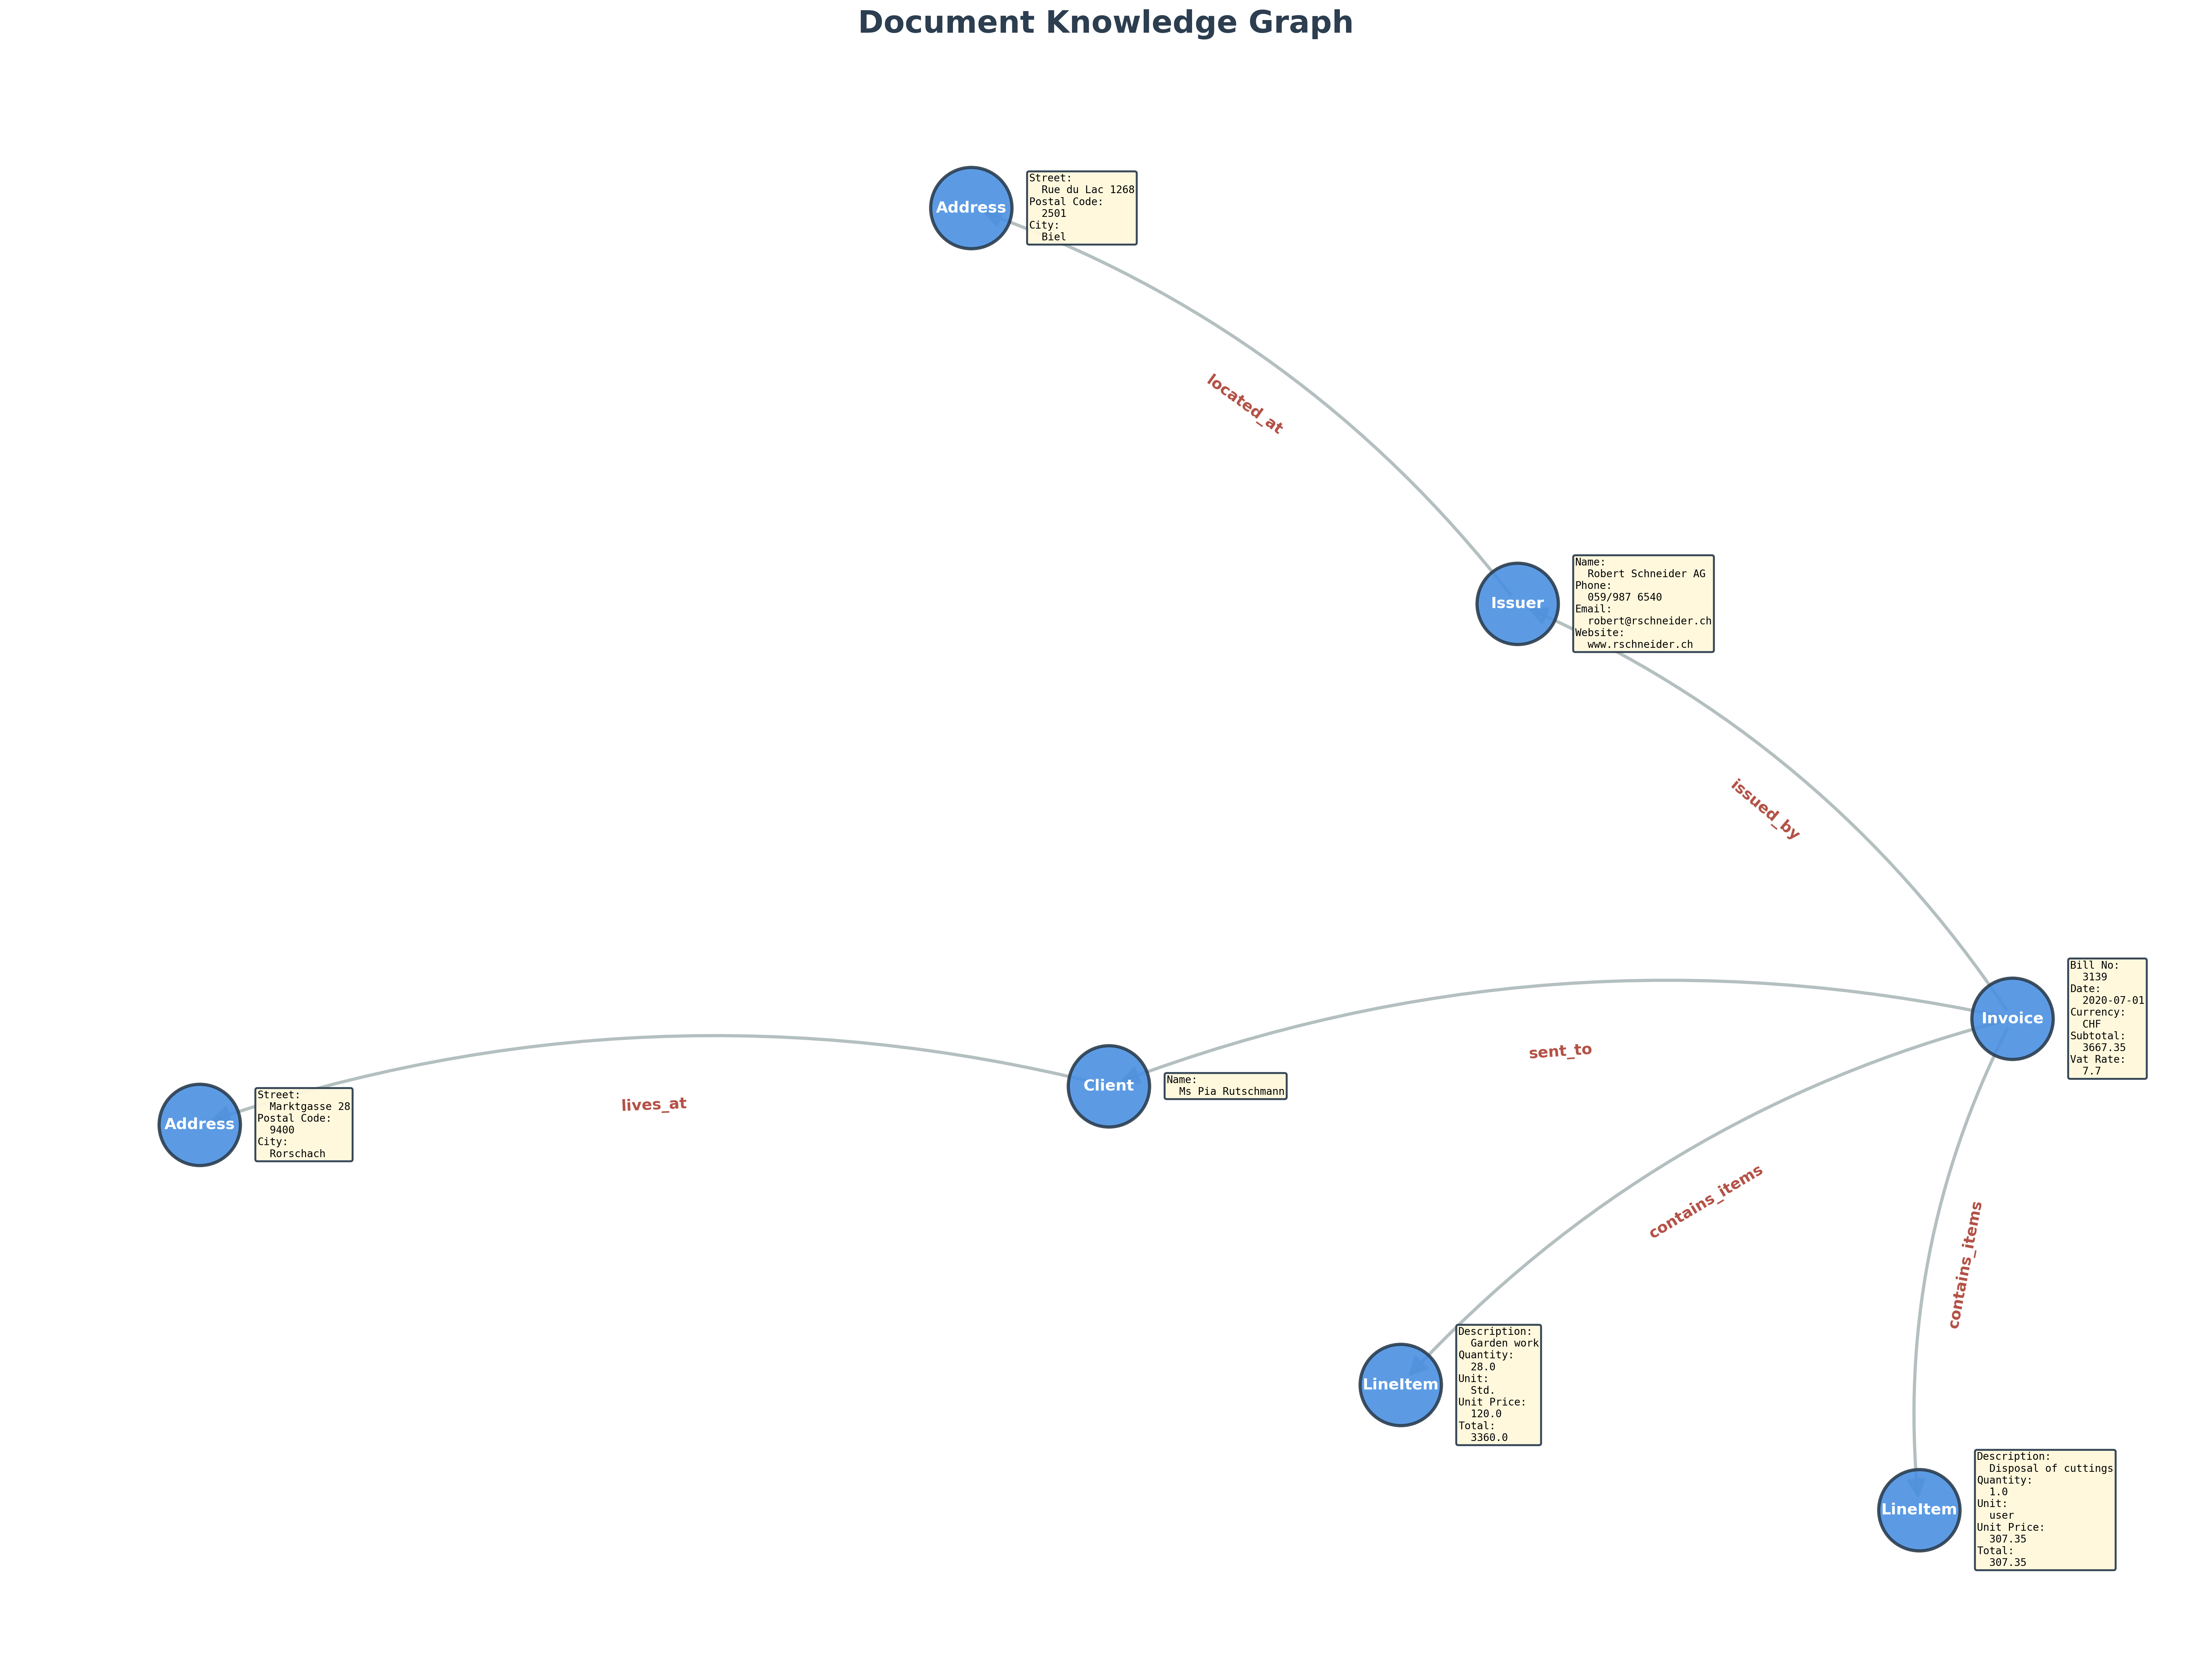

In [50]:
# Find and display the PNG visualization
png_files = list(output_dir.glob("*.png"))

if png_files:
    png_file = png_files[0]
    print(f"Graph Visualization: {png_file.name}\n")
    display(Image(filename=str(png_file), width=1200))
else:
    print("No PNG visualization found")

## Step 7: View Interactive Graph (HTML)

The interactive HTML visualization allows you to:
- Drag and rearrange nodes
- Zoom in/out
- Click nodes to see details
- Explore relationships

In [21]:
# Find the HTML file
html_files = list(output_dir.glob("*.html"))

if html_files:
    html_file = html_files[0]
    print(f"Interactive Graph: {html_file.name}")
    print(f"    Open in browser: file://{html_file.absolute()}")
    
else:
    print("No HTML visualization found")

Interactive Graph: sample_invoice_graph.html
    Open in browser: file://d:\Users\Ayoub\Capsule\Rrepositories\GitHub\docling-graph\notebooks\..\outputs\notebook_example\sample_invoice_graph.html


## Step 8: Load and Analyze the Knowledge Graph

Now let's load the graph into NetworkX and perform some analysis.

**Display Nodes Data**

In [52]:
# Read nodes CSV
nodes_csv = output_dir / "graph/nodes.csv"

if nodes_csv.exists():
    nodes_df = pd.read_csv(nodes_csv)
    
    print("EXTRACTED DATA - NODES")
    print("=" * 70)
    print(f"\nTotal Nodes: {len(nodes_df)}\n")
    
    # Display nodes (drop empty columns, replace NaN with empty string)
    nodes_display = nodes_df.dropna(axis=1, how='all').fillna('')
    display(nodes_display)
else:
    print("Nodes CSV file not found")

EXTRACTED DATA - NODES

Total Nodes: 7



,id:ID,label:LABEL,bill_no,date,currency,subtotal,vat_rate,vat_amount,total,name,phone,email,website,street,postal_code,city,description,quantity,unit,unit_price
0,Invoice_c7f2ee76b706,Invoice,3139.0,2020-07-01,CHF,3667.35,7.7,282.4,3949.75,,,,,,,,,,,
1,Issuer_613c8041a0ac,Issuer,,,,,,,,Robert Schneider AG,059/987 6540,robert@rschneider.ch,www.rschneider.ch,,,,,,,
2,Address_52dae2cc0f4f,Address,,,,,,,,,,,,Rue du Lac 1268,2501.0,Biel,,,,
3,Client_ce831394e191,Client,,,,,,,,Ms Pia Rutschmann,,,,,,,,,,
4,Address_382f08e7c1cc,Address,,,,,,,,,,,,Marktgasse 28,9400.0,Rorschach,,,,
5,LineItem_2efae2ae49dc,LineItem,,,,,,,3360.0,,,,,,,,Garden work,28.0,Std.,120.0
6,LineItem_6af91c7fdbba,LineItem,,,,,,,307.35,,,,,,,,Disposal of cuttings,1.0,user,307.35


**Display Relationships Data**

In [51]:
# Read relationships CSV
rels_csv = output_dir / "graph/relationships.csv"

if rels_csv.exists():
    rels_df = pd.read_csv(rels_csv)
    
    print("EXTRACTED DATA - RELATIONSHIPS")
    print("=" * 70)
    print(f"\nTotal Relationships: {len(rels_df)}\n")
    
    # Display relationships (replace NaN with empty string)
    rels_display = rels_df.dropna(axis=1, how='all').fillna('')
    display(rels_display)
else:
    print("Relationships CSV file not found")


EXTRACTED DATA - RELATIONSHIPS

Total Relationships: 6



,:START_ID,:END_ID,:TYPE,cardinality,index
0,Invoice_c7f2ee76b706,Issuer_613c8041a0ac,issued_by,one-to-one,
1,Invoice_c7f2ee76b706,Client_ce831394e191,sent_to,one-to-one,
2,Invoice_c7f2ee76b706,LineItem_2efae2ae49dc,contains_items,one-to-many,0.0
3,Invoice_c7f2ee76b706,LineItem_6af91c7fdbba,contains_items,one-to-many,1.0
4,Issuer_613c8041a0ac,Address_52dae2cc0f4f,located_at,one-to-one,
5,Client_ce831394e191,Address_382f08e7c1cc,lives_at,one-to-one,


## Step 9: Query the Graph

Let's explore what entities were extracted from the invoice.

**Load Graph into NetworkX**

In [53]:
# Read CSV files
nodes_csv = output_dir / "graph/nodes.csv"
rels_csv = output_dir / "graph/relationships.csv"

if nodes_csv.exists() and rels_csv.exists():
    nodes_df = pd.read_csv(nodes_csv)
    rels_df = pd.read_csv(rels_csv)
    
    print("LOADING GRAPH INTO NETWORKX")
    print("=" * 70)
    
    graph = nx.DiGraph()
    
    # Handle Neo4j CSV format column names
    node_id_col = 'id:ID' if 'id:ID' in nodes_df.columns else 'id'
    node_label_col = 'label:LABEL' if 'label:LABEL' in nodes_df.columns else 'label'
    
    # Add nodes
    for _, node in nodes_df.iterrows():
        node_id = node[node_id_col]
        node_dict = node.to_dict()
        
        # Rename Neo4j columns to standard names
        if 'id:ID' in node_dict:
            node_dict['id'] = node_dict.pop('id:ID')
        if 'label:LABEL' in node_dict:
            node_dict['label'] = node_dict.pop('label:LABEL')
        
        graph.add_node(node_id, **node_dict)
    
    # Handle relationship columns
    start_col = ':START_ID' if ':START_ID' in rels_df.columns else 'source'
    end_col = ':END_ID' if ':END_ID' in rels_df.columns else 'target'
    type_col = ':TYPE' if ':TYPE' in rels_df.columns else 'type'
    
    # Add edges
    for _, rel in rels_df.iterrows():
        source = rel[start_col]
        target = rel[end_col]
        
        rel_dict = rel.to_dict()
        
        # Rename Neo4j columns
        if ':START_ID' in rel_dict:
            rel_dict['source'] = rel_dict.pop(':START_ID')
        if ':END_ID' in rel_dict:
            rel_dict['target'] = rel_dict.pop(':END_ID')
        if ':TYPE' in rel_dict:
            rel_dict['type'] = rel_dict.pop(':TYPE')
        
        graph.add_edge(source, target, **rel_dict)
    
    print(f"\nGraph loaded into NetworkX")
    print(f"  Nodes: {graph.number_of_nodes()}")
    print(f"  Edges: {graph.number_of_edges()}")
    
    # Show node types
    node_types = {}
    for node_id, data in graph.nodes(data=True):
        label = data.get('label', 'Unknown')
        node_types[label] = node_types.get(label, 0) + 1
    
    print(f"\nNode Types:")
    for label, count in node_types.items():
        print(f"  • {label}: {count}")

else:
    print("CSV files not found")
    graph = None

LOADING GRAPH INTO NETWORKX

Graph loaded into NetworkX
  Nodes: 7
  Edges: 6

Node Types:
  • Invoice: 1
  • Issuer: 1
  • Address: 2
  • Client: 1
  • LineItem: 2


**Find Entities by Type**

In [40]:
if graph:
    # Group nodes by type (label)
    node_types = {}
    for node_id, data in graph.nodes(data=True):
        label = data.get('label', 'Unknown')
        if label not in node_types:
            node_types[label] = []
        node_types[label].append((node_id, data))
    
    print("Entities by Type:")
    print("=" * 70)
    
    for label, nodes in node_types.items():
        print(f"\n{label} ({len(nodes)} node(s)):")
        for node_id, data in nodes:
            print(f"  • {node_id}")
            # Show some key properties
            for key, value in data.items():
                if key not in ['id', 'label'] and value and str(value) != 'nan':
                    print(f"    - {key}: {value}")

Entities by Type:

Invoice (1 node(s)):
  • Invoice_c7f2ee76b706
    - bill_no: 3139.0
    - date: 2020-07-01
    - currency: CHF
    - subtotal: 3667.35
    - vat_rate: 7.7
    - vat_amount: 282.4
    - total: 3949.75

Issuer (1 node(s)):
  • Issuer_613c8041a0ac
    - name: Robert Schneider AG
    - phone: 059/987 6540
    - email: robert@rschneider.ch
    - website: www.rschneider.ch

Address (2 node(s)):
  • Address_52dae2cc0f4f
    - street: Rue du Lac 1268
    - postal_code: 2501.0
    - city: Biel
  • Address_382f08e7c1cc
    - street: Marktgasse 28
    - postal_code: 9400.0
    - city: Rorschach

Client (1 node(s)):
  • Client_ce831394e191
    - name: Ms Pia Rutschmann

LineItem (2 node(s)):
  • LineItem_2efae2ae49dc
    - total: 3360.0
    - description: Garden work
    - quantity: 28.0
    - unit: Std.
    - unit_price: 120.0
  • LineItem_6af91c7fdbba
    - total: 307.35
    - description: Disposal of cuttings
    - quantity: 1.0
    - unit: user
    - unit_price: 307.35
